In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
import matplotlib.pyplot as plt
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Load Tweet dataset download from https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset**

In [ ]:
!wget "https://drive.google.com/uc?id=15sp8c4hh8T8EmP8xZ-y681oZjpaNqJUN&export=download" -O data.csv -q
df = pd.read_csv("/content/data.csv")

#Output the first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


<Axes: xlabel='category'>

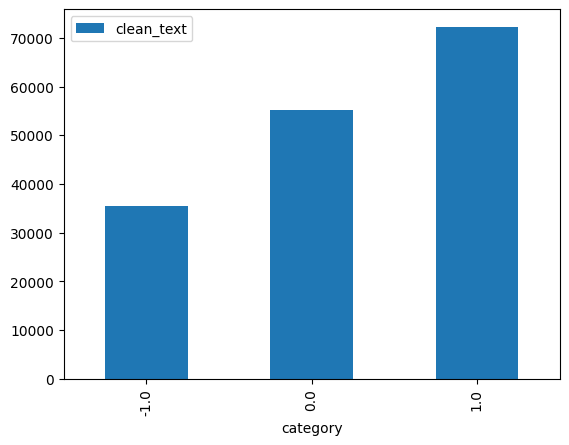

In [ ]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

In [ ]:
# # Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# **Visualizing data into wordclouds**

In [ ]:
from wordcloud import WordCloud, STOPWORDS

#generate the worldcloud

def wordcount_gen(data, color):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    #fill code

    words = ' '.join(map(str, data))
    word = " ".join([word for word in words.split()
                    if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'])

    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                      width=2500,
                      height=2000
                     ).generate(word)

    plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

    #fill code

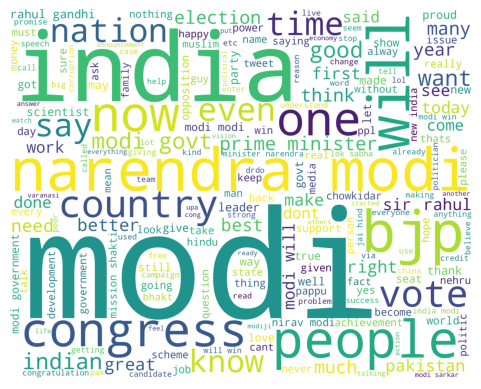

In [ ]:
#Generate Positive tweet words cloud
pos = [j for i , j in enumerate(df['clean_text']) if df['category'][i]=='Positive' ]
wordcount_gen(pos, 'white')


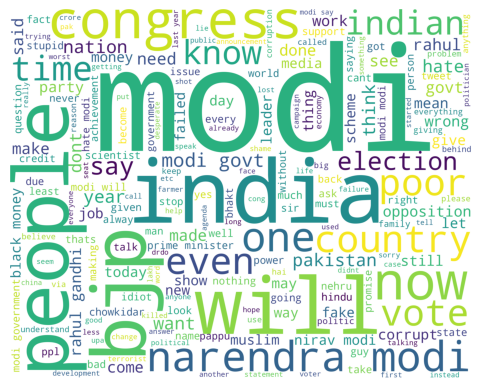

In [ ]:
#Generate Negative tweet words cloud
neg = [j for i , j in enumerate(df['clean_text']) if df['category'][i]=='Negative']
wordcount_gen(neg, 'white')

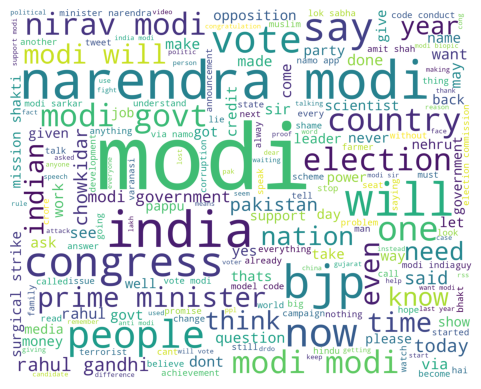

In [ ]:
#Generate Neutral tweet words cloud
neutral = [j for i , j in enumerate(df['clean_text']) if df['category'][i]=='Neutral']
wordcount_gen(neutral, 'white')

# **Cleaning the tweets using RegEx and NLTK**

In [ ]:
#return the cleaned tweet using RegEx and NLTK
def tweet_to_words(tweet):

    ''' Convert tweet text into a sequence of words '''

    tweet = str(tweet)

    tweet = tweet.replace("’ ", "")
    tweet = tweet.replace(" – ", " ")

    words = list(tweet.split())

    stopwords_list = set(stopwords.words("english"))
    no_stopwords = ["not","don't",'aren','don','ain',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                  'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                  "won't", 'wouldn', "wouldn't"]
    for no_stopword in no_stopwords:
        stopwords_list.remove(no_stopword)

    re_negation = re.compile("n't")
    def negation_abbreviated_to_standard(sent):
        sent = re_negation.sub(" not", sent)
        return sent

    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    def lemma_stem_text(words_list):
        text = [lemmatizer.lemmatize(token.lower()) for token in words_list]
        text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]
        return text

    def clean(review_text):

        review_text = negation_abbreviated_to_standard(review_text)

        letters_numbers_only = re.sub("/[^\x00-\x7F]+/", " ", review_text)

        words = np.char.lower(letters_numbers_only.split())

        meaningful_words = [w for w in words if not w in stopwords_list]

        lemma_words = lemma_stem_text(meaningful_words)
        return(lemma_words)

    new_tweet = []

    for i in words:
      new_word= clean(i)
      if new_word!=None:
        new_tweet+= new_word

    new_tweet_str = ' '.join([str(i) for i in new_tweet])

    return new_tweet_str

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> modi promise “minimum government maximum governance” expect begin difficult job reform state take year get justice state not business exit psus temple


In [ ]:
# Applying data processing to each tweet
for i , j in enumerate(df['clean_text'].tolist()):
  df['clean_text'][i] = tweet_to_words(j)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding target labels using scikit learn

le =LabelEncoder()
df['category'] = le.fit_transform(df['category'])

df.head()

,clean_text,category
0,modi promise “minimum government maximum gover...,0
1,talk nonsense continue drama vote modi,1
2,say vote modi welcome bjp tell rahul main camp...,2
3,ask supporter prefix chowkidar name modi great...,2
4,answer among powerful world leader today trump...,2


In [ ]:
#train test splitting using scikit learn
from sklearn.model_selection import train_test_split
# y = pd.get_dummies(df['category'])
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], df['category'], test_size = 0.2, random_state=104, shuffle=True)

#**Train Test Split for training the Regression model**

In [ ]:
#Transform the training and testing data using countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2))
train_data = vectorizer.fit_transform(x_train)
train_data.shape

(130384, 904905)

In [ ]:
#train multivariate logistic regression on the data using scikit learn
from sklearn.linear_model import LogisticRegression
# Define the model
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# Train model
model.fit(train_data, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

In [ ]:
#predict using your model on the testing dataset
test_data = vectorizer.transform(x_test)

result = model.predict(test_data)

y_pred = result

# **Analysing the Results**

Text(0.5, 427.9555555555555, 'Predicted label')

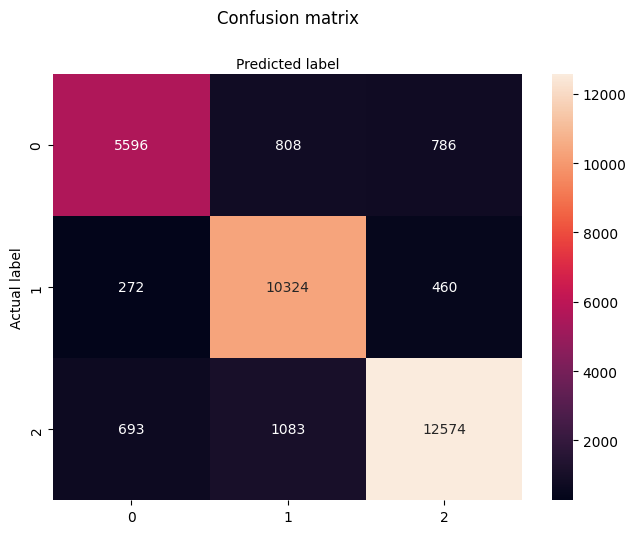

In [ ]:
#Calculate and plot the Confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
import seaborn as sns
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  color = 'Red'  ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [ ]:
#calculate the precision , recall and accuracy using scikit learn

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))

Accuracy: 0.8741563382010062
Precision: 0.8693166375165594
Recall: 0.8627772463509453
